In [1]:
import gymnasium as gym
import tensorflow as tf
import numpy as np
import statistics
from tensorflow.keras import Model, layers
from tensorflow.keras.layers import Flatten, Dense
import collections
import tqdm
import matplotlib.pyplot as plt
from datetime import datetime

env = gym.make("ALE/SpaceInvaders-v5", obs_type="ram", render_mode='rgb_array', frameskip=1, repeat_action_probability=0)
folder = "videos/" + str(datetime.now().time()).replace(":","_")
env = gym.wrappers.RecordVideo(env=env, video_folder=folder, name_prefix="breakout", episode_trigger=lambda x: x % 1 == 0, disable_logger=True)

seed = 21
tf.random.set_seed(seed)
np.random.seed(seed)

eps = np.finfo(np.float32).eps.item()

In [2]:
class ActorCritic(tf.keras.Model):
  """Combined actor-critic network."""

  def __init__(
      self,
      num_actions: int,
      num_hidden_units: int):
    """Initialize."""
    super().__init__()

    self.common = layers.Dense(num_hidden_units, activation="relu")
    self.actor = layers.Dense(num_actions)
    self.critic = layers.Dense(1)

  def call(self, inputs: tf.Tensor):
    x = self.common(inputs)
    return self.actor(x), self.critic(x)

In [3]:
num_actions = env.action_space.n
num_hidden_units = 512

model = ActorCritic(num_actions, num_hidden_units)

In [4]:
@tf.numpy_function(Tout=[tf.float32, tf.int32, tf.int32])
def env_step(action: np.ndarray):
  """Returns state, reward and done flag given an action."""

  state, reward, done, truncated, info = env.step(action)
  return (state.astype(np.float32),
          np.array(reward, np.int32),
          np.array(done, np.int32))

In [5]:
def run_episode(
    initial_state: tf.Tensor,
    model: tf.keras.Model,
    max_steps: int):
    """Runs a single episode to collect training data."""
    
    action_probs = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
    values = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
    rewards = tf.TensorArray(dtype=tf.int32, size=0, dynamic_size=True)
    
    initial_state_shape = initial_state.shape
    state = initial_state
    
    for t in tf.range(max_steps):
        # Convert state into a batched tensor (batch size = 1)
        state = tf.expand_dims(state, 0)
        
        # Run the model and to get action probabilities and critic value
        action_logits_t, value = model(state)
        
        # Sample next action from the action probability distribution
        action = tf.random.categorical(action_logits_t, 1)[0, 0]
        action_probs_t = tf.nn.softmax(action_logits_t)
        
        # Store critic values
        values = values.write(t, tf.squeeze(value))
        
        # Store log probability of the action chosen
        action_probs = action_probs.write(t, action_probs_t[0, action])
        
        # Apply action to the environment to get next state and reward
        state, reward, done = env_step(action)
        state.set_shape(initial_state_shape)
        
        # Store reward
        rewards = rewards.write(t, reward)
        
        if tf.cast(done, tf.bool):
          break
    
    action_probs = action_probs.stack()
    values = values.stack()
    rewards = rewards.stack()
    
    return action_probs, values, rewards

In [6]:
def get_expected_return(
    rewards: tf.Tensor,
    gamma: float,
    standardize: bool = True):
  """Compute expected returns per timestep."""

  n = tf.shape(rewards)[0]
  returns = tf.TensorArray(dtype=tf.float32, size=n)

  # Start from the end of `rewards` and accumulate reward sums
  # into the `returns` array
  rewards = tf.cast(rewards[::-1], dtype=tf.float32)
  discounted_sum = tf.constant(0.0)
  discounted_sum_shape = discounted_sum.shape
  for i in tf.range(n):
    reward = rewards[i]
    discounted_sum = reward + gamma * discounted_sum
    discounted_sum.set_shape(discounted_sum_shape)
    returns = returns.write(i, discounted_sum)
  returns = returns.stack()[::-1]

  if standardize:
    returns = ((returns - tf.math.reduce_mean(returns)) /
               (tf.math.reduce_std(returns) + eps))

  return returns

In [7]:
huber_loss = tf.keras.losses.Huber(reduction=tf.keras.losses.Reduction.SUM)

def compute_loss(
    action_probs: tf.Tensor,
    values: tf.Tensor,
    returns: tf.Tensor) -> tf.Tensor:
  """Computes the combined Actor-Critic loss."""

  advantage = returns - values

  action_log_probs = tf.math.log(action_probs)
  actor_entropy = -tf.math.reduce_sum(action_probs * action_log_probs)
  actor_loss = -tf.math.reduce_sum(action_log_probs * advantage) - (50 * actor_entropy)
  critic_loss = huber_loss(values, returns)

  return actor_loss + critic_loss

In [8]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00015)

@tf.function
def train_step(
    initial_state: tf.Tensor,
    model: tf.keras.Model,
    optimizer: tf.keras.optimizers.Optimizer,
    gamma: float,
    max_steps_per_episode: int) -> tf.Tensor:
  """Runs a model training step."""

  with tf.GradientTape() as tape:

    # Run the model for one episode to collect training data
    action_probs, values, rewards = run_episode(
        initial_state, model, max_steps_per_episode)

    # Calculate the expected returns
    returns = get_expected_return(rewards, gamma)

    # Convert training data to appropriate TF tensor shapes
    action_probs, values, returns = [
        tf.expand_dims(x, 1) for x in [action_probs, values, returns]]

    # Calculate the loss values to update our network
    loss = compute_loss(action_probs, values, returns)

  # Compute the gradients from the loss
  grads = tape.gradient(loss, model.trainable_variables)

  # Apply the gradients to the model's parameters
  optimizer.apply_gradients(zip(grads, model.trainable_variables))

  episode_reward = tf.math.reduce_sum(rewards)

  return episode_reward
  #return episode_reward if episode_reward is not None else -3

In [9]:
%%time

max_episodes = 5000
max_steps_per_episode = 100000

reward_threshold = 0
running_reward = 0

# The discount factor for future rewards
gamma = 0.99

# Keep the last episodes reward
episodes_reward = []
running_totals = []
#epsodes_reward_50 = collections.deque = collections.deque(maxlen=50)

t = tqdm.trange(max_episodes)
for i in t:
    initial_state, info = env.reset()
    env.start_video_recorder()
    initial_state = tf.constant(initial_state, dtype=tf.float32)
    episode_reward = int(train_step(
        initial_state, model, optimizer, gamma, max_steps_per_episode))

    episodes_reward.append(episode_reward)
    #episodes_reward_50.append(episode_reward)
    running_reward = statistics.mean(episodes_reward)
    running_totals.append(running_reward)

    t.set_postfix(
        episode_reward=episode_reward, running_reward=running_reward)

    if i % 100 == 0:
        print(f'Episode {i}: average reward: {running_reward}')

    env.close_video_recorder()


print(f'\nSolved at episode {i}: average reward: {running_reward:.2f}!')

  0%|                                                                                         | 0/5000 [00:00<?, ?it/s]C:\Users\miles\anaconda3\Lib\site-packages\gymnasium\utils\passive_env_checker.py:335: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(
  0%|                                         | 1/5000 [00:02<3:01:07,  2.17s/it, episode_reward=55, running_reward=55]

Episode 0: average reward: 55


  0%|▏                                        | 25/5000 [00:32<1:48:46,  1.31s/it, episode_reward=0, running_reward=41]


KeyboardInterrupt: 

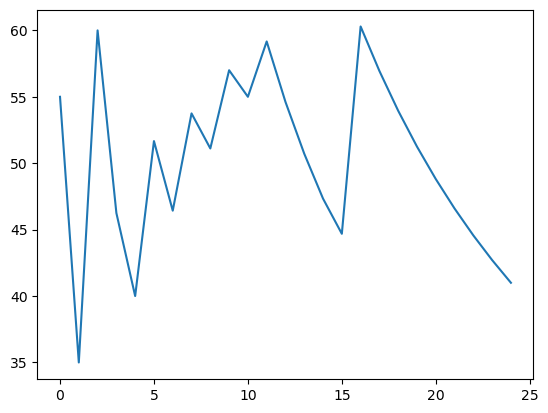

In [10]:
#plt.plot(episodes_reward)
plt.plot(running_totals)
plt.savefig(str(datetime.now().time()).replace(":","_") + '.png')